# 一、数据预处理

In [1]:
import pandas as pd

df = pd.read_csv('../data/qualitydata_3/jmt0718withGeoLocation.csv')

print df.shape
print df.columns.values
#  print df.dtypes
#  print df.describe(include='all') 
df.head(10)

(140172, 21)
['CONFID' 'GID' 'UID_' 'USERTYPE' 'PLATFORM' 'STARTJOINTIME' 'JOINEDTIME'
 'CUSTOMERPCIP' 'CUSTOMERGWIP' 'GATEWAYIP' 'REFNUM6' 'USEROS' 'USERBROWSER'
 'DOWNLOADMETHOD' 'SERVICETYPE' 'SITEID' 'USERJMT' 'SITEVERSION' 'COUNTRY'
 'REGION' 'CITY']


,CONFID,GID,UID_,USERTYPE,PLATFORM,STARTJOINTIME,JOINEDTIME,CUSTOMERPCIP,CUSTOMERGWIP,GATEWAYIP,...,USEROS,USERBROWSER,DOWNLOADMETHOD,SERVICETYPE,SITEID,USERJMT,SITEVERSION,COUNTRY,REGION,CITY
0,67675035056255840,1363137257,0,New,1,2017-07-17 00:04:55,17/07/2017 00:02,192.168.1.3,203.219.118.114:0,203.219.118.114,...,intel mac os x 10.11,Chrome 59,Extension,MC,303790,5,T32L,Australia,New South Wales,Drummoyne
1,67677775728783700,0,484596012,Return,1,2017-07-17 00:29:21,17/07/2017 00:30,173.39.68.67,114.29.212.251:29689,114.29.212.251,...,intel mac os x 10.11,Chrome 59,Extension,MC,303790,41,T32L,Singapore,NaN,NaN
2,67426686169297830,0,482189042,Return,0,2017-07-17 01:29:48,17/07/2017 01:30,10.67.229.89,10.67.229.89:0,10.67.229.89,...,Windows 7,Other,Unknown,MC,303790,22,T32L,Unknown,Unknown,Unknown
3,67456423214231739,0,488814472,Return,1,2017-07-17 00:27:43,17/07/2017 00:27,10.116.161.229,10.116.161.229:0,10.116.161.229,...,intel mac os x 10.6,Chrome 10,Unknown,MC,303790,5,T32L,Unknown,Unknown,Unknown
4,67427580115988892,1363146907,0,Return,0,2017-07-17 00:20:37,17/07/2017 00:17,10.28.1.122,64.68.126.92:17423,64.68.126.92,...,Windows 10,Firefox 54,Extension,MC,303790,6,T32L,United States,California,San Jose
5,67676153274479589,0,488296597,Return,0,2017-07-17 00:03:33,17/07/2017 00:03,173.39.68.45,173.39.68.45:0,173.39.68.45,...,Windows 10,Firefox 54,Extension,MC,303790,9,T32L,India,Karnataka,Bengaluru
6,64533326108602815,0,488509517,Return,0,2017-07-17 00:26:31,17/07/2017 00:26,10.65.94.136,72.163.220.10:0,72.163.220.10,...,Windows 10,Chrome 59,Extension,MC,303790,4,T32L,India,Karnataka,Bengaluru
7,67676780464484504,0,482137882,Return,0,2017-07-17 01:03:02,17/07/2017 01:03,10.137.0.136,10.137.0.136:0,10.137.0.136,...,Windows 10,Firefox 54,Extension,MC,303790,6,T32L,Unknown,Unknown,Unknown
8,66684394406982360,0,487470242,Return,0,2017-07-17 01:01:37,17/07/2017 01:01,10.137.80.109,10.137.80.109:0,10.137.80.109,...,Windows 7,IE 11.0,ActiveX,MC,303790,7,T32L,Unknown,Unknown,Unknown
9,67679482515862121,0,487685352,Return,0,2017-07-17 00:56:28,17/07/2017 00:56,173.39.68.73,173.39.68.73:0,173.39.68.73,...,Windows 10,Chrome 59,Extension,MC,303790,6,T32L,India,Karnataka,Bengaluru


In [2]:
# 把REGION和CITY字段为 NaN 的部分填充为 Unknown
df.COUNTRY= df.COUNTRY.fillna('Unknown')
df.REGION= df.REGION.fillna('Unknown')
df.CITY = df.CITY.fillna('Unknown')

In [3]:
# 生成新字段ID，用GID或UID的值表示
df.insert(0,'ID',df.GID+df.UID_)

# 生成新字段register，0表示为注册用户，1表示为没注册用户。uid对应0，gid对应1
bool_to_num =  {False:0, True: 1}
register = (df['GID']!=0).map(bool_to_num)
df.insert(6,'REGISTER',register)

# 并且原来的删除GID和UID两个字段
del df['GID']
del df['UID_']

In [4]:
# 生成HOUR和TIMESTAMP字段
import time 

def rowkey_to_hour(startjointime):
    return time.strptime(startjointime, '%Y-%m-%d %H:%M:%S').tm_hour

def rowkey_to_timestamp(startjointime):
    return int(time.mktime(time.strptime(startjointime, '%Y-%m-%d %H:%M:%S')))

HOUR = df.STARTJOINTIME.map(rowkey_to_hour)
df.insert(2,'HOUR',HOUR)

TIMESTAMP = df.STARTJOINTIME.map(rowkey_to_timestamp)
df.insert(3,'TIMESTAMP',TIMESTAMP)

In [5]:
# 分析 country、region、city，并对这三者进行处理
# ============ 出现频率小于某个阈值的类别统一划分为other==============

def category_unify(category_field, threshold):
    field_count_dict = df[category_field].value_counts()<threshold
    index_field_dict ={}
    for index, field in df[category_field].iteritems():
        index_field_dict[index] = field_count_dict[field]
    return pd.Series(index_field_dict)  
    
df.loc[category_unify('COUNTRY', 1000), 'COUNTRY' ] = "Other"
df.loc[category_unify('REGION', 1000), 'REGION' ] = "Other"
df.loc[category_unify('CITY', 1000), 'CITY' ] = "Other"


# df_dis_series = df.COUNTRY.value_counts()
# country_flag_series = df_dis_series<=30
# for country,flag in country_flag_series.iteritems():
#     if flag:
#         df.COUNTRY.replace(country,"other",inplace=True)
# # 原来是 130 个 country，划分后为 71 个 country      

# df_dis_series = df.REGION.value_counts()
# region_flag_series = df_dis_series<=10
# for region,flag in region_flag_series.iteritems():
#     if flag:
#         df.REGION.replace(region,"other",inplace=True)
# # 原来是 674 个region，划分后为 171 个 region

# df_dis_series = df.CITY.value_counts()
# city_flag_series = df_dis_series<=10
# for city,flag in city_flag_series.iteritems():
#     if flag:
#         df.CITY.replace(city,"other",inplace=True)
# # 原来是 2849 个city，划分后为 312 个city      

In [6]:
# 对于 USEROS 和 USERBROWSER 进行分析处理
# 生成 PC、moblie特征
from collections import OrderedDict 

o_dict = OrderedDict()
o_dict['Phone'] = 'Moblie'
o_dict['Android'] = 'Moblie'
o_dict['iOS'] = 'Moblie'
o_dict['Other'] = 'Other'
o_dict['Windows'] = 'PC'
o_dict['Linux'] = 'PC'
o_dict['intel mac os x'] = 'PC'
o_dict['Chrome OS'] = 'PC'

def category_unify_by_char(category_field):
    index_field_dict = {}
    for index, field in df[category_field].iteritems():
        for useros, flag in o_dict.items():
            if useros in field:
                index_field_dict[index] = flag
                break
    return pd.Series(index_field_dict)  

MACHINE_TYPE = category_unify_by_char('USEROS')
df['MACHINE_TYPE'] = MACHINE_TYPE

df.loc[category_unify('USEROS', 1000), 'USEROS' ] = "Other"
df.loc[category_unify('USERBROWSER', 1000), 'USERBROWSER' ] = "Other"

In [7]:
# 保存中间数据集到 csv
df.to_csv('../data/qualitydata_3/jmt0718withGeoLocation_clean.csv',index=False)
df.head()

,ID,CONFID,HOUR,TIMESTAMP,USERTYPE,PLATFORM,REGISTER,STARTJOINTIME,JOINEDTIME,CUSTOMERPCIP,...,USERBROWSER,DOWNLOADMETHOD,SERVICETYPE,SITEID,USERJMT,SITEVERSION,COUNTRY,REGION,CITY,MACHINE_TYPE
0,1363137257,67675035056255840,0,1500221095,New,1,1,2017-07-17 00:04:55,17/07/2017 00:02,192.168.1.3,...,Chrome 59,Extension,MC,303790,5,T32L,Australia,Other,Other,PC
1,484596012,67677775728783700,0,1500222561,Return,1,0,2017-07-17 00:29:21,17/07/2017 00:30,173.39.68.67,...,Chrome 59,Extension,MC,303790,41,T32L,Singapore,Unknown,Unknown,PC
2,482189042,67426686169297830,1,1500226188,Return,0,0,2017-07-17 01:29:48,17/07/2017 01:30,10.67.229.89,...,Other,Unknown,MC,303790,22,T32L,Unknown,Unknown,Unknown,PC
3,488814472,67456423214231739,0,1500222463,Return,1,0,2017-07-17 00:27:43,17/07/2017 00:27,10.116.161.229,...,Chrome 10,Unknown,MC,303790,5,T32L,Unknown,Unknown,Unknown,PC
4,1363146907,67427580115988892,0,1500222037,Return,0,1,2017-07-17 00:20:37,17/07/2017 00:17,10.28.1.122,...,Firefox 54,Extension,MC,303790,6,T32L,United States,California,San Jose,PC


# 二、JMT处理

In [1]:
import pandas as pd
df = pd.read_csv('../data/SAP_MEETINGJMT_20170810-20170825/SAP_MEETINGJMT_20170810.csv')

pd.set_option('display.max_rows',None)
print df.USERJMT.value_counts()[0:100]

AttributeError: 'DataFrame' object has no attribute 'USERJMT'

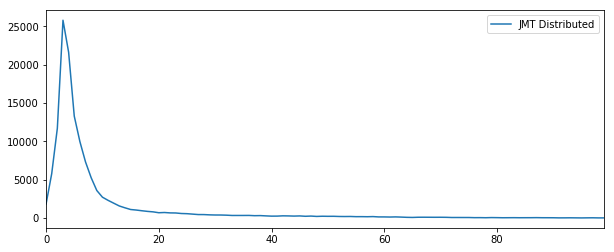

0      1850
1      5801
2     11727
3     25808
4     21639
5     13307
6      9984
7      7327
8      5273
9      3605
10     2734
11     2322
12     1952
13     1586
14     1348
15     1128
16     1057
17      965
18      882
19      820
20      706
21      737
22      686
23      675
24      606
25      583
26      526
27      469
28      466
29      430
30      411
31      409
32      388
33      350
34      351
35      351
36      356
37      322
38      334
39      296
40      263
41      267
42      302
43      291
44      269
45      290
46      244
47      271
48      226
49      250
50      239
51      242
52      219
53      212
54      219
55      194
56      197
57      186
58      204
59      161
60      160
61      146
62      163
63      138
64      108
65       94
66      118
67      121
68      117
69      113
70      116
71      108
72       85
73       86
74       84
75       84
76       65
77       68
78       56
79       75
80       67
81       53
82       58
83  

In [2]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

plt.figure(figsize=(10, 4))
count_series = df.USERJMT.value_counts().sort_index()[0:100]
count_series.plot(label='JMT Distributed')
plt.legend()
plt.show()

print count_series[0:100]

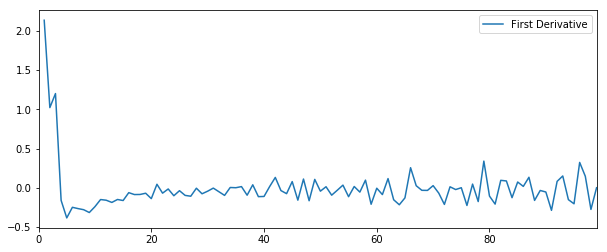

In [3]:
# 查看一阶导数分布
plt.figure(figsize=(10, 4))
count_series.pct_change().plot(label='First Derivative')
plt.legend()
plt.show()

观察4-5的变化率，和5-6的变化率

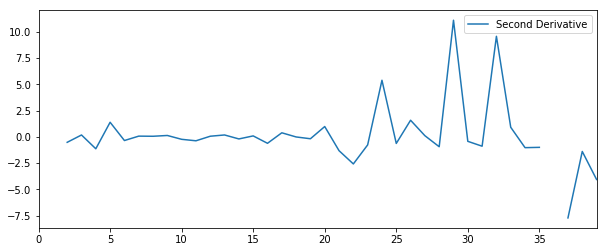

0           NaN
1           NaN
2     -0.521675
3      0.175406
4     -1.134534
5      1.383606
6     -0.351458
7      0.065704
8      0.053385
9      0.128402
10    -0.236209
11    -0.376286
12     0.057404
13     0.176689
14    -0.199664
15     0.087574
16    -0.614329
17     0.382813
18    -0.011816
19    -0.182717
20     0.977734
21    -1.315839
22    -2.575962
23    -0.768279
24     5.374949
25    -0.628713
26     1.576031
27     0.108365
28    -0.940972
29    11.077253
30    -0.428036
31    -0.889871
32     9.551345
33     0.907462
34    -1.029173
35    -1.000000
36          inf
37    -7.704494
38    -1.390208
39    -4.052894
Name: USERJMT, dtype: float64


In [4]:
# 查看二阶导数分布

plt.figure(figsize=(10, 4))
count_series.pct_change().pct_change()[0:40].plot(label='Second Derivative')
plt.legend()
plt.show()

print count_series.pct_change().pct_change()[0:40]

1. 更加印证了 jmt > 20 是比较合理的。
2. 想把0-5归为一个区间段、6-20归为一个区间段是比较合理的。

In [5]:
# USERJMT 字段进行映射为[0,2]
def jmt_map(x):
    if 0 <= x <= 5:
        return 2
    elif 6 <= x <= 20:
        return 1
    elif 20 < x :
        return 0

df['USERJMT_DIS'] = df.USERJMT.map(jmt_map)
df.USERJMT_DIS.value_counts()

2    80132
1    41689
0    18351
Name: USERJMT_DIS, dtype: int64

In [6]:
df.to_excel('../data/qualitydata_3/jmt0718withGeoLocation_clean_map.xlsx',index=False)

# 三、单字段分析

   count  percentage
5  80132    0.571669
4  37259    0.265809
3  10019    0.071476
2   8063    0.057522
1   4699    0.033523


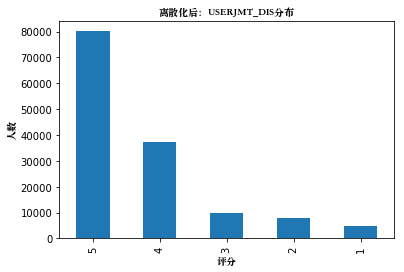

In [9]:
# USERJMT_DIS 分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  

myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')  

fig = plt.figure()
fig.set(alpha=0.4)  # 设定图表颜色alpha参数

df.USERJMT_DIS.value_counts().plot(kind='bar')# 柱状图 
plt.title(u"离散化后：USERJMT_DIS分布", fontproperties=myfont) # 标题
plt.ylabel(u"人数", fontproperties=myfont)
plt.xlabel(u"评分", fontproperties=myfont)

userjmt_dis_series = df.USERJMT_DIS.value_counts()
userjmt_dis_series_per = userjmt_dis_series/df.shape[0]
print pd.concat([userjmt_dis_series.to_frame(name='count'),userjmt_dis_series_per.to_frame(name='percentage')],axis=1)

plt.show()

结论: 大部分都是正常的评分，少部分是异常评分


### 2.1 REGISTER 与JMT分析

0    111239
1     28933
Name: REGISTER, dtype: int64

1分的分布:
   count  percentage:%
0   2518      2.263595
1   2181      7.538105

2分的分布:
   count  percentage:%
0   4886      4.392344
1   3177     10.980541

3分的分布:
   count  percentage:%
0   7045       6.33321
1   2974      10.27892

4分的分布:
   count  percentage:%
0  32137     28.890048
1   5122     17.702969

5分的分布:
   count  percentage:%
0  64653     58.120803
1  15479     53.499464


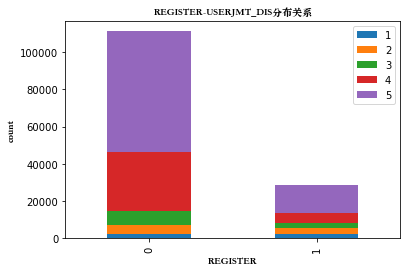

In [10]:
# REGISTER 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

# fig = plt.figure()
# fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Score_1 = df.REGISTER[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.REGISTER[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.REGISTER[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.REGISTER[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.REGISTER[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"REGISTER-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"REGISTER",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.REGISTER.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()


结论： 在差评评分中（1-2分），在未注册的比例是已注册的3倍左右。

(4886+2518)/111239 = 6.66% <br>
(3177+2181)/28933 = 18.5%

### 2.2 USERTYPE 与JMT分析

Return    120507
Update     16088
New         3577
Name: USERTYPE, dtype: int64

1分的分布:
        count  percentage:%
New       584     16.326531
Return    635      0.526940
Update   3480     21.631029

2分的分布:
        count  percentage:%
New       655     18.311434
Return   2244      1.862132
Update   5164     32.098458

3分的分布:
        count  percentage:%
Return   5423      4.500154
Update   4164     25.882645
New       432     12.077160

4分的分布:
        count  percentage:%
Return  33798     28.046504
Update   2453     15.247389
New      1008     28.180039

5分的分布:
        count  percentage:%
New       898     25.104836
Return  78407     65.064270
Update    827      5.140477


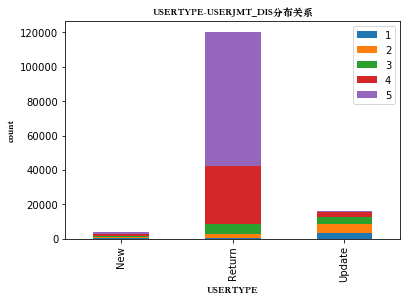

In [11]:
# USERTYPE 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.USERTYPE[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.USERTYPE[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.USERTYPE[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.USERTYPE[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.USERTYPE[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"USERTYPE-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"USERTYPE",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.USERTYPE.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论：在差评（1-2分）中<br>
Return 比例非常少。(361+1169)/120507 = 1.27% <br>Update比例最高。(1940+4887)/16088 = 42.4%<br>New比例其次。(386+599)/3577 = 27.5%


### 2.3 PLATFORM 与JMT分析

0     83066
1     43011
10     6870
7      5456
13     1406
15      360
12        2
4         1
Name: PLATFORM, dtype: int64

1分的分布:
     count  percentage:%
0   3842.0      4.625238
1    841.0      1.955314
4      NaN           NaN
7      9.0      0.164956
10     NaN           NaN
12     NaN           NaN
13     6.0      0.426743
15     1.0      0.277778

2分的分布:
     count  percentage:%
0   6288.0      7.569884
1   1693.0      3.936202
4      NaN           NaN
7     47.0      0.861437
10     NaN           NaN
12     NaN           NaN
13    35.0      2.489331
15     NaN           NaN

3分的分布:
     count  percentage:%
0   8553.0     10.296632
1   1388.0      3.227081
4      NaN           NaN
7     61.0      1.118035
10     NaN           NaN
12     NaN           NaN
13    12.0      0.853485
15     5.0      1.388889

4分的分布:
      count  percentage:%
0   28273.0     34.036790
1    8146.0     18.939341
4       1.0    100.000000
7     544.0      9.970674
10      NaN           NaN
12      2.0 

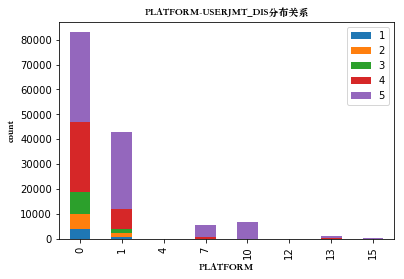

In [12]:
# PLATFORM 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.PLATFORM[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.PLATFORM[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.PLATFORM[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.PLATFORM[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.PLATFORM[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"PLATFORM-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"PLATFORM",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.PLATFORM.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论： 在差评中，PLATFORM = 0 类型的比例远大于其他类型的比例。其次是PLATFORM = 1类型的比例。

### 2.4 REFNUM6 与JMT分析

0     95044
17    23523
16     7771
15     5984
41     3872
22     1616
2      1304
51      596
43      459
45        1
28        1
8         1
Name: REFNUM6, dtype: int64

1分的分布:
     count  percentage:%
0   3716.0      3.909768
2     27.0      2.070552
8      NaN           NaN
15    23.0      0.384358
16    17.0      0.218762
17   481.0      2.044807
22    14.0      0.866337
28     NaN           NaN
41   386.0      9.969008
43    14.0      3.050109
45     NaN           NaN
51    21.0      3.523490

2分的分布:
     count  percentage:%
0   5940.0      6.249737
2     77.0      5.904908
8      NaN           NaN
15    68.0      1.136364
16    35.0      0.450392
17  1282.0      5.449985
22    40.0      2.475248
28     NaN           NaN
41   577.0     14.901860
43    20.0      4.357298
45     NaN           NaN
51    24.0      4.026846

3分的分布:
     count  percentage:%
0   5808.0      6.110854
2    185.0     14.187117
8      1.0    100.000000
15    82.0      1.370321
16    25.0      0.321709
17  

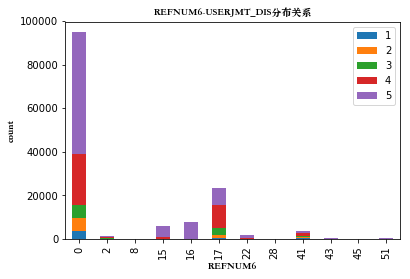

In [13]:
# REFNUM6 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.REFNUM6[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.REFNUM6[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.REFNUM6[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.REFNUM6[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.REFNUM6[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"REFNUM6-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"REFNUM6",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.REFNUM6.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论
REFNUM6 = 41 以及 =0 的比例是最高的。


### 2.5 USEROS 与JMT分析

Windows 7               38535
Windows 10              30415
intel mac os x 10.12    22521
intel mac os x 10.11    12039
Windows 8.1             11468
Other                    9270
iOS                      6109
intel mac os x 10.6      4413
intel mac os x 10.10     2533
Android 9.12             1266
intel mac os x 10.7       596
Windows Vista             356
intel mac os x 10.9       210
Windows 8                 122
Linux_Other                68
Android 9.11               44
Chrome OS                  33
Linux_Ubuntu               33
Android 9.10               26
intel mac os x 10.13       21
Windows XP                 18
Android 9.9                15
Android 9.8                11
Linux_Fedora               11
Android 9.5                 9
intel mac os x 10.8         8
Android 9.7                 6
Android 9.13                4
Android 9.6                 4
Android 9.0                 3
Android 9.1                 3
Windows Phone               1
Android 4.0                 1
Name: USER

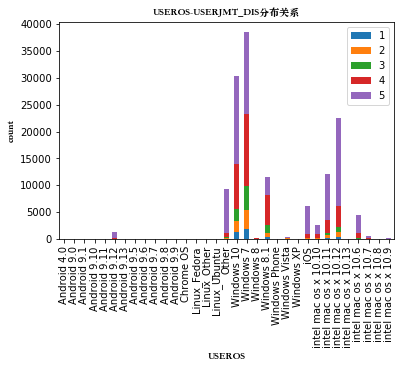

In [14]:
# USEROS 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.USEROS[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.USEROS[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.USEROS[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.USEROS[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.USEROS[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"USEROS-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"USEROS",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.USEROS.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论： 在差评（1-2分）中mac系列还是比windows系列表现要好。主要看intel mac os x 10.10、10.11、10.12 和Windows 7、Windows 8、Windows 10对比。

### 2.6 USERBROWSER 与JMT分析

Chrome 59                           35510
Other                               32808
Firefox 54                          21637
IE 11.0                             20866
Safari 10                           12458
Chrome 10                            4413
Chrome 58                            2126
IE 6.0                               1323
Android 9.12.0.19120114.19120114     1266
Chrome 51                            1062
IE 10.0                               835
Firefox 52                            684
Firefox 53                            670
Chrome 34                             600
Chrome 46                             466
IE 7.0                                372
Safari 9                              283
Firefox 55                            230
Chrome 52                             213
Firefox 47                            177
Chrome 60                             165
Chrome 57                             154
Chrome 56                             148
IE 8.0                            

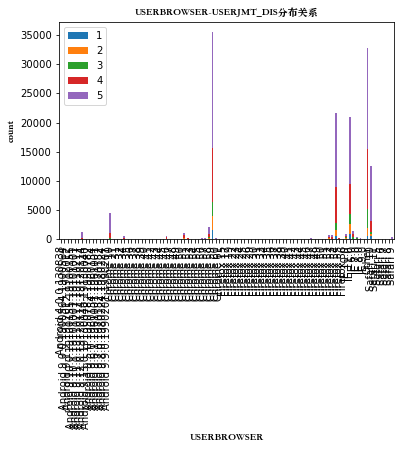

In [15]:
# USERBROWSER 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.USERBROWSER[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.USERBROWSER[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.USERBROWSER[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.USERBROWSER[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.USERBROWSER[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"USERBROWSER-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"USERBROWSER",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.USERBROWSER.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print

pd.set_option('display.max_rows',None)

print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论: 这个字段的结论不明显

### 2.7 DOWNLOADMETHOD 与JMT分析

Extension                    60708
Unknown                      40886
ActiveX                      22305
GPC Plugin                   14109
TFS                           2071
Java Applet Native Client       93
Name: DOWNLOADMETHOD, dtype: int64

1分的分布:
                           count  percentage:%
ActiveX                      993      4.451917
Extension                   2275      3.747447
GPC Plugin                   550      3.898221
Java Applet Native Client     19     20.430108
TFS                          132      6.373732
Unknown                      730      1.785452

2分的分布:
                           count  percentage:%
ActiveX                     1874      8.401704
Extension                   3693      6.083218
GPC Plugin                   575      4.075413
Java Applet Native Client     24     25.806452
TFS                          223     10.767745
Unknown                     1674      4.094311

3分的分布:
                           count  percentage:%
ActiveX                   

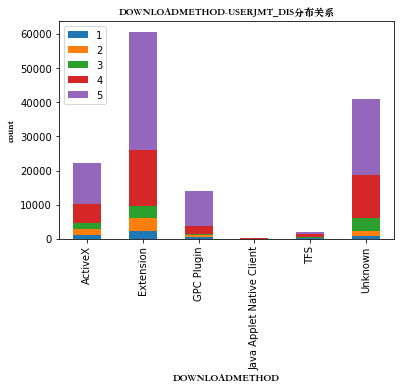

In [16]:
# DOWNLOADMETHOD 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.DOWNLOADMETHOD[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.DOWNLOADMETHOD[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.DOWNLOADMETHOD[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.DOWNLOADMETHOD[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.DOWNLOADMETHOD[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"DOWNLOADMETHOD-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"DOWNLOADMETHOD",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.DOWNLOADMETHOD.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论: Java Applet Native Client 低分较多，但是样本量偏少。<br>
&emsp;&emsp;&emsp;不过 Extension 和 GPC Plugin 低分中比例偏少。


### 2.8 SERVICETYPE 与JMT分析

MC         139764
TC            274
EC            103
SC             16
UNKNOWN        15
Name: SERVICETYPE, dtype: int64

1分的分布:
          count  percentage:%
EC          8.0      7.766990
MC       4668.0      3.339916
SC          NaN           NaN
TC         22.0      8.029197
UNKNOWN     1.0      6.666667

2分的分布:
         count  percentage:%
EC          31     30.097087
MC        7972      5.703901
SC           1      6.250000
TC          55     20.072993
UNKNOWN      4     26.666667

3分的分布:
         count  percentage:%
EC          20     19.417476
MC        9890      7.076214
SC           3     18.750000
TC         101     36.861314
UNKNOWN      5     33.333333

4分的分布:
         count  percentage:%
MC       37145     26.576944
TC          70     25.547445
EC          27     26.213592
SC          12     75.000000
UNKNOWN      5     33.333333

5分的分布:
           count  percentage:%
EC          17.0     16.504854
MC       80089.0     57.303025
SC           NaN           NaN
TC          

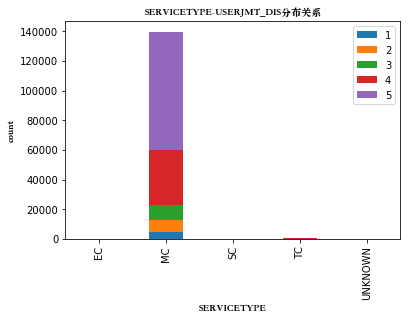

In [17]:
# SERVICETYPE 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.SERVICETYPE[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.SERVICETYPE[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.SERVICETYPE[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.SERVICETYPE[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.SERVICETYPE[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"SERVICETYPE-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"SERVICETYPE",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.SERVICETYPE.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论：MC好评率最高。不过这个字段中各个值得分布也不平均，MC占据了大多数。


### 2.9 SITEVERSION 与JMT分析

T32L    140170
T31L         2
Name: SITEVERSION, dtype: int64

1分的分布:
       count  percentage:%
T31L     NaN           NaN
T32L  4699.0      3.352358

2分的分布:
       count  percentage:%
T31L     NaN           NaN
T32L  8063.0      5.752301

3分的分布:
        count  percentage:%
T31L      NaN           NaN
T32L  10019.0      7.147749

4分的分布:
      count  percentage:%
T32L  37258     26.580581
T31L      1     50.000000

5分的分布:
      count  percentage:%
T32L  80131     57.167011
T31L      1     50.000000


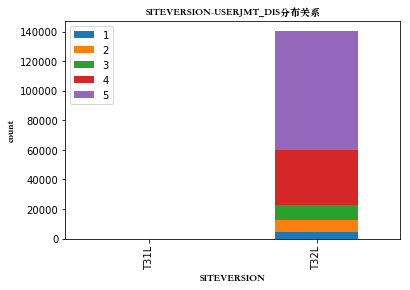

In [18]:
# REFNUM6 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.SITEVERSION[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.SITEVERSION[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.SITEVERSION[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.SITEVERSION[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.SITEVERSION[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"SITEVERSION-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"SITEVERSION",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.SITEVERSION.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

结论：这个字段没什么分析意义。。。


### 2.10 HOUR 与JMT分析

17    13249
16    12894
15    12725
18    11741
14    10543
20     9241
19     8780
13     7871
21     6504
8      5196
9      5180
12     4827
6      4255
22     4132
5      3744
10     3623
7      3591
11     3092
23     2670
4      2223
2      1333
3      1285
1      1006
0       467
Name: HOUR, dtype: int64

1分的分布:
    count  percentage:%
0      27      5.781585
1      88      8.747515
2     145     10.877719
3      80      6.225681
4     135      6.072874
5     350      9.348291
6     379      8.907168
7     291      8.103592
8     354      6.812933
9     365      7.046332
10    265      7.314380
11    186      6.015524
12    195      4.039776
13    266      3.379494
14    269      2.551456
15    267      2.098232
16    255      1.977664
17    199      1.502000
18    173      1.473469
19    120      1.366743
20    119      1.287739
21     72      1.107011
22     56      1.355276
23     43      1.610487

2分的分布:
    count  percentage:%
0      61     13.062099
1     124     12.326044

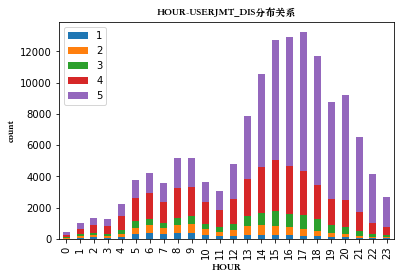

In [19]:
# HOUR 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.HOUR[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.HOUR[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.HOUR[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.HOUR[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.HOUR[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"HOUR-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"HOUR",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.HOUR.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

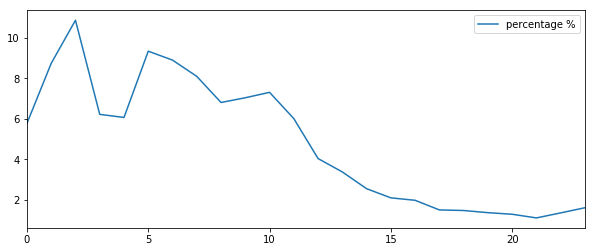

In [21]:
# 当评分为1分时，时间（hour为单位）和 比例的分布图
plt.figure(figsize=(10, 4))
Score_1_per.plot(label='percentage %')
plt.legend()
plt.show()

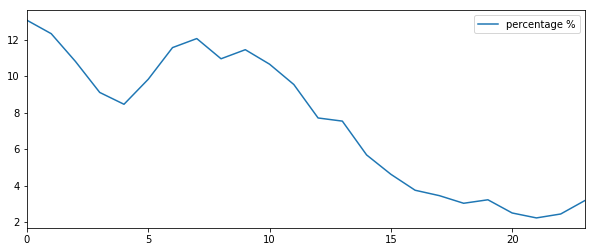

In [22]:
# 当评分为2分时，时间（hour为单位）和 比例的分布图

plt.figure(figsize=(10, 4))
Score_2_per.plot(label='percentage %')
plt.legend()
plt.show()

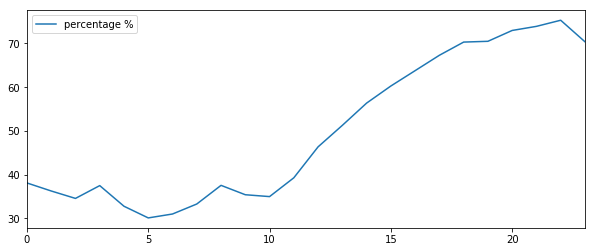

In [23]:
# 当评分为5分时，时间（hour为单位）和 比例的分布图

plt.figure(figsize=(10, 4))
Score_5_per.plot(label='percentage %')
plt.legend()
plt.show()

结论：0-10点开会时，差评比例很高。

### 2.11 COUNTRY 与JMT分析

Unknown                        68437
United States                  24331
India                          15191
Netherlands                    14586
Singapore                       6288
Hong Kong                       1803
United Kingdom                  1351
Australia                       1023
Israel                           885
Mexico                           700
Canada                           675
Germany                          540
China                            472
Italy                            251
Brazil                           241
France                           205
Taiwan                           200
Russia                           162
Spain                            154
Thailand                         145
Saudi Arabia                     128
United Arab Emirates             118
Colombia                         118
Poland                           112
South Africa                     109
Switzerland                      100
Japan                             88
U

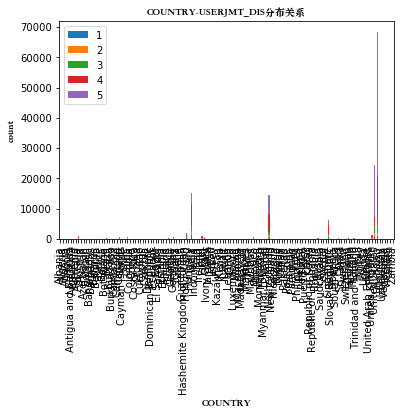

In [24]:
# COUNTRY 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.COUNTRY[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.COUNTRY[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.COUNTRY[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.COUNTRY[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.COUNTRY[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"COUNTRY-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"COUNTRY",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.COUNTRY.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

### 2.12 REGION	与JMT分析

Unknown                                            78289
Provincie Flevoland                                14172
Karnataka                                          13720
California                                         12900
North Carolina                                      2335
Central Singapore Community Development Council     1647
Texas                                               1104
New York                                             936
New South Wales                                      887
Central District                                     750
Illinois                                             574
New Jersey                                           520
Georgia                                              426
Florida                                              423
Virginia                                             383
Ontario                                              372
Colorado                                             339
Massachusetts                  

                                                  count  percentage:%
Aargau                                              5.0     62.500000
Aberdeenshire                                       NaN           NaN
Abidjan                                             NaN           NaN
Abu Dhabi                                           1.0      4.347826
Aisne                                               NaN           NaN
Akershus                                            1.0     50.000000
Al Asimah                                           2.0     10.526316
Al Batinah North Governorate                        1.0     25.000000
Al Fujayrah                                         NaN           NaN
Al Madinah al Munawwarah                            NaN           NaN
Alabama                                             5.0     13.513514
Alaska                                              2.0     20.000000
Alberta                                             7.0      6.796117
Alexandria          

                                                   count  percentage:%
Aargau                                               2.0     25.000000
Aberdeenshire                                        NaN           NaN
Abidjan                                              NaN           NaN
Abu Dhabi                                            1.0      4.347826
Aisne                                                1.0    100.000000
Akershus                                             NaN           NaN
Al Asimah                                            4.0     21.052632
Al Batinah North Governorate                         NaN           NaN
Al Fujayrah                                          NaN           NaN
Al Madinah al Munawwarah                             NaN           NaN
Alabama                                             10.0     27.027027
Alaska                                               2.0     20.000000
Alberta                                             37.0     35.922330
Alexan

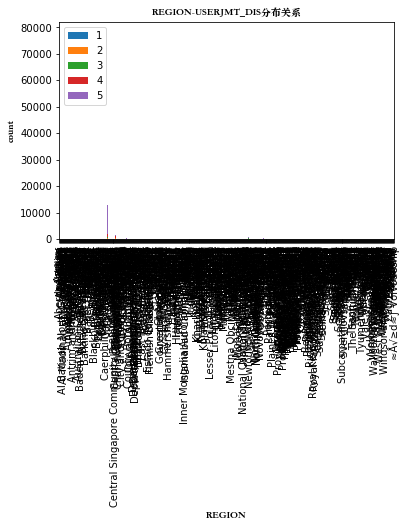

In [26]:
# REGION 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

Score_1 = df.REGION[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.REGION[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.REGION[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.REGION[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.REGION[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"REGION-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"REGION",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.REGION.value_counts()

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

### 2.13 CITY 与JMT分析

In [151]:
# CITY 和JMT的数据分布
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  
myfont = FontProperties(fname='/Library/Fonts/Songti.ttc')

# ============ 出现频率小于某个阈值的类别统一划分为other==============
df_dis_series = df.CITY.value_counts()
# print '=====',len(df_dis_series)
city_flag_series = df_dis_series<=10
for city,flag in city_flag_series.iteritems():
    if flag:
        df.CITY.replace(city,"other",inplace=True)
# 原来是 2849 个city，划分后为 312 个city      
# ==============================================================

Score_1 = df.CITY[df.USERJMT_DIS == 1].value_counts()
Score_2 = df.CITY[df.USERJMT_DIS == 2].value_counts()
Score_3 = df.CITY[df.USERJMT_DIS == 3].value_counts()
Score_4 = df.CITY[df.USERJMT_DIS == 4].value_counts()
Score_5 = df.CITY[df.USERJMT_DIS == 5].value_counts()
pd.DataFrame({u'1':Score_1, u'2':Score_2, u'3':Score_3, u'4':Score_4, u'5':Score_5}).plot(kind='bar', stacked=True)
plt.title(u"CITY-USERJMT_DIS分布关系",fontproperties=myfont)
plt.xlabel(u"CITY",fontproperties=myfont) 
plt.ylabel(u"count",fontproperties=myfont) 


df_dis_series = df.CITY.value_counts()

print df_dis_series

Score_1_per = Score_1/df_dis_series * 100
Score_2_per = Score_2/df_dis_series * 100
Score_3_per = Score_3/df_dis_series * 100
Score_4_per = Score_4/df_dis_series * 100
Score_5_per = Score_5/df_dis_series * 100


print df_dis_series
print
print '1分的分布:\n',pd.concat([Score_1.to_frame(name='count'), Score_1_per.to_frame(name='percentage:%')],axis=1)
print '\n2分的分布:\n',pd.concat([Score_2.to_frame(name='count'), Score_2_per.to_frame(name='percentage:%')],axis=1)
print '\n3分的分布:\n',pd.concat([Score_3.to_frame(name='count'), Score_3_per.to_frame(name='percentage:%')],axis=1)
print '\n4分的分布:\n',pd.concat([Score_4.to_frame(name='count'), Score_4_per.to_frame(name='percentage:%')],axis=1)
print '\n5分的分布:\n',pd.concat([Score_5.to_frame(name='count'), Score_5_per.to_frame(name='percentage:%')],axis=1)

plt.show()

===== 2849
===== 312
Unknown               79497
Almere Stad           14172
Bengaluru             13672
San Jose               8938
other                  5769
Morrisville            1749
Singapore              1647
San Francisco          1268
Netanya                 734
St Leonards             711
Mexico City             320
Castro Valley           306
New York                288
The Bronx               281
London                  214
Amsterdam               212
Chicago                 200
Union City              199
Los Angeles             196
Houston                 195
Dallas                  177
Toronto                 170
Hyderabad               144
Denver                  137
Beijing                 135
Chennai                 132
Mumbai                  130
Fremont                 128
Pune                    127
Bangkok                 120
Taipei                  112
Cary                    110
Sunnyvale               108
Santa Clara             107
Brooklyn                102